In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NetVanilla(nn.Module):
    def __init__(self):
        super(NetVanilla, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [2]:
from torchvision import datasets, transforms

batch_size = 100
test_batch_size = 1


transform = transforms.ToTensor()

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True, transform=transform),
        batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transform),
        batch_size=test_batch_size, shuffle=False)


In [3]:
def train(model, device, train_loader, optimizer, epoch, verbose=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)

        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))



def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    av_conf = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            c, pred = output.max(1, keepdim=True) # get the index of the max log-probability
            correct += (pred.eq(target.view_as(pred))*(c.exp()>0.5)).sum().item()
            av_conf += c.exp().sum().item()
            
    test_loss /= len(test_loader.dataset)
    av_conf /= len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Ave. Confidence: {:.0f}%\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset), 100. * av_conf))
    return correct, av_conf

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [5]:
model = torch.load('base_model').to(device)

In [6]:
import matplotlib.pyplot as plt
data = enumerate(test_loader).__next__()[1][0]
model.eval()
y = model(data.to(device))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(str(y.argmax(1)[i].item()) + ":   %.2f" % y[i].max().exp().item())
    plt.imshow(data[i].squeeze(), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
#plt.show()

IndexError: index 1 is out of bounds for dimension 0 with size 1

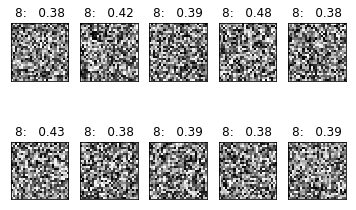

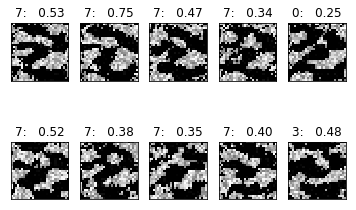

In [94]:
noise = (2*data.mean()*torch.rand((10,1,28,28)))
y = model(noise.to(device))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(str(y.argmax(1)[i].item()) + ":   %.2f" % y[i].max().exp().item())
    plt.imshow(noise[i].squeeze(), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
plt.show()
    
noise = noise.to(device).requires_grad_()
y = model(noise)
loss = y.sum()

loss.backward()

epsilon = .2
image = noise[0]
for _ in range(3):
    
    perturbed_image = noise + epsilon*noise.grad.sign()
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    delta = perturbed_image
    perturbed_image = perturbed_image.detach()



model.eval()
y = model(perturbed_image.to(device))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(str(y.argmax(1)[i].item()) + ":   %.2f" % y[i].max().exp().item())
    plt.imshow(perturbed_image.cpu()[i].squeeze(), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [55]:
noise = (2*data.mean()*torch.rand((10,1,28,28)))
noise = noise.to(device).requires_grad_()


epsilon = 3.5
alpha = .01
image = noise
perturbed_image = image
for _ in range(10):
    y = model(perturbed_image)
    loss = -y.sum()
    loss.backward()
    
    with torch.no_grad():
        perturbed_image += alpha*image.grad
        # Adding clipping to maintain [0,1] range
        delta = perturbed_image-image
        delta /= delta.view((10,784)).norm(dim=1)[:,None,None,None]
        delta *= epsilon
        perturbed_image = image + delta
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        print(str(loss.item()) + '\t'+ str((perturbed_image-image).view((10,784)).norm(dim=1).max().item()))
        perturbed_image = perturbed_image.detach()

250.48794555664062	25.495168685913086
1192.736083984375	3.500000238418579
338.41033935546875	3.500000476837158
352.3938903808594	3.500000238418579
366.65289306640625	3.5000007152557373
380.7513122558594	3.500000238418579
394.68853759765625	3.500000238418579
408.4053955078125	3.500000238418579
421.74993896484375	3.5000007152557373
434.6178894042969	3.500000476837158


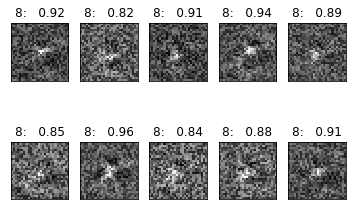

In [56]:
model.eval()
y = model(perturbed_image.to(device))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(str(y.argmax(1)[i].item()) + ":   %.2f" % y[i].max().exp().item())
    plt.imshow(perturbed_image.cpu()[i].squeeze(), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [72]:
robust_model = torch.load('model')

249.24517822265625	25.495637893676758
230.26123046875	7.000000953674316
230.26220703125	7.000000476837158
230.2623291015625	7.000000476837158
230.2623291015625	7.000000953674316
230.2618408203125	7.000001430511475
230.26129150390625	7.000000476837158
230.26080322265625	7.000000476837158
230.26177978515625	7.000000953674316
230.2628173828125	7.000001430511475


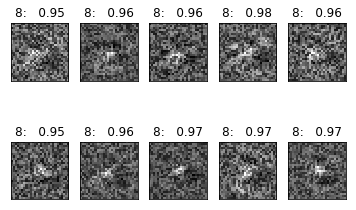

In [74]:
robust_model.eval()
y = model(perturbed_image.to(device))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(str(y.argmax(1)[i].item()) + ":   %.2f" % y[i].max().exp().item())
    plt.imshow(perturbed_image.cpu()[i].squeeze(), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [70]:
robust_model.gmm(perturbed_image.view(10,784)).max(dim=0)

(tensor([-753.4155, -753.1851, -753.4005, -753.7383, -753.0765, -753.8444,
         -753.5245, -753.8726, -753.0617, -752.7513], device='cuda:0',
        grad_fn=<MaxBackward0>),
 tensor([904, 904, 904, 904, 904, 904, 904, 904, 904, 904], device='cuda:0'))

In [59]:
import torch
import math
import numpy as np

import torch.nn as nn

from sklearn.cluster import KMeans
import numpy as np

class GMM(nn.Module):
    
    
    def __init__(self, K, D):
        """
        Initializes means, variances and weights randomly
        :param K: number of gaussians
        :param D: number of features
        """
        super(GMM, self).__init__()

        self.D = D
        self.K = K
        self.mu = nn.Parameter(torch.rand(K, D))
        self.logvar = nn.Parameter(torch.rand(K))
        self.alpha = nn.Parameter(torch.empty(K).fill_(1. / K))

        self.logvarbound = 0
        self.NORM_CONST = torch.tensor(2*math.pi).log()
    
    def forward(self, X):
        """
        Compute the likelihood of each data point under each gaussians.
        :param X: design matrix (examples, features) (N,D)
        :return likelihoods: (K, examples) (K, N)
        """
        if self.alpha.min() < 0:
            self.prune()
        a = ((X[None,:,:]-self.mu[:,None,:])**2).sum(-1)
        b = self.logvar[:,None].exp()
        return (self.alpha.log()[:,None] 
                - .5*( self.D*self.NORM_CONST 
                      + self.D*self.logvar[:,None] 
                      + a/b ) )
                                          
    
    def get_posteriors(self, X):
        log_like = self.forward(X)
        log_post = log_like - self.logsumexp(log_like, dim=0, keepdim=True)
        return log_post
    
    def EM_step(self, X):
        log_post = self.get_posteriors(X)
        post = log_post.exp()
        Nk = post.sum(dim=1)
        
        self.mu.data = (post[:,:,None]*X[None,:,:]).sum(dim=1) / Nk[:,None]
        temp = log_post + ((X[None,:,:]-self.mu[:,None,:])**2).sum(dim=-1).log()
        self.logvar.data = (- Nk.log() 
                       + self.logsumexp(temp, dim=1, keepdim=False))
        
        self.alpha.data = Nk/Nk.sum()
        
    def find_solution(self, X, initialize=True, iterate=True):
        
        assert X.device==self.mu.device, 'Data stored on ' + str(X.device) + ' but model on ' + str(self.mu.device)
        
        with torch.no_grad():
            if initialize:
                m = X.size(0)
                idxs = torch.from_numpy(np.random.choice(m, self.K, replace=False)).long()
                self.mu.data = X[idxs]
                
                # find variance within its cluster
                kmeans = KMeans(n_clusters=self.K, random_state=0, max_iter=300).fit(X.cpu())
                #index = kmeans.predict(X_MNIST.cpu())
                self.mu.data = torch.tensor(kmeans.cluster_centers_, dtype=torch.float, device=self.mu.device)
                index = (X[:,None,:]-torch.tensor(self.mu.data[None,:,:], dtype=torch.float)).norm(dim=2).min(dim=1)[1]
                for i in range(self.K):
                    assert (index==i).sum()>0, 'Empty cluster'
                    self.alpha.data[i] = (index==i).float().sum() / self.K
                    temp = (X_MNIST[index==i,:] -self.mu.data[i,:]).norm(dim=1).mean()
                    if temp < 0.00001:
                        temp = torch.tensor(1.)
                    self.logvar.data[i] = temp.log() * 2

                
                #self.logvar.data = torch.empty(self.K, device=self.mu.device).fill_( (X.var() / self.K).log() ) + 6
                #self.alpha.data = torch.empty(self.K, device=self.mu.device).fill_(1. / self.K)
                self.logvarbound = (X.var() / m).log()

            if iterate:
                for _ in range(500):
                    mu_prev = self.mu
                    logvar_prev = self.logvar
                    alpha_prev = self.alpha
                    self.EM_step(X)
                    self.logvar.data[self.logvar < self.logvarbound] = self.logvarbound

                    delta = torch.stack( ((mu_prev-self.mu).abs().max(),
                                (logvar_prev-self.logvar).abs().max(),
                                (alpha_prev-self.alpha).abs().max()) ).max()

                    if delta<10e-6:
                        break

    def prune(self):
        """
        prunes away negative gaussians
        """
        with torch.no_grad():
            index = torch.nonzero(self.alpha > 0)

            self.mu = nn.Parameter(self.mu[index].squeeze(1))
            self.logvar = nn.Parameter(self.logvar[index].squeeze(1))
            self.alpha = nn.Parameter(self.alpha[index].squeeze(1))
            self.K = len(index)
    
    @staticmethod
    def logsumexp(x, dim, keepdim=False):
        """
        :param x: input data
        :param dim: dimension to sum over
        :param keepdim: whether it should squeeze that dimension
        :return:
        """
        max, _ = torch.max(x, dim=dim, keepdim=True)
        out = max.squeeze() + (x - max).exp().sum(dim=dim, keepdim=keepdim).log()
        return out

class Net(nn.Module):
    def __init__(self, base_model, X, K, loglam):
        super(Net, self).__init__()
        self.base_model = base_model
        
        self.gmm = GMM(K, 784)
        self.gmm.find_solution(X, iterate=False)
        #self.log_pz_lam = -784*torch.tensor(i).log().to(device)
        self.log_pz_lam = nn.Parameter(torch.tensor(loglam, dtype=torch.float))
        self.log_K = -torch.tensor(10.).log()
        
        
    def forward(self, x):
        batch_size = x.shape[0]
        likelihood_per_peak = self.gmm(x.view(batch_size, 784))
        like = self.gmm.logsumexp(likelihood_per_peak, 0)

        x = self.base_model(x)
        
        a1 = torch.stack( (x + like[:,None], (self.log_pz_lam + self.log_K)*torch.ones_like(x) ), 0)
        b1 = self.gmm.logsumexp(a1, 0).squeeze()

        a2 = torch.stack( (like , (self.log_pz_lam)*torch.ones_like(like) ), 0)
        b2 = self.gmm.logsumexp(a2, 0).squeeze()[:,None]

        return b1-b2
